In [129]:
import matplotlib
%matplotlib inline 

matplotlib.rc('figure', figsize=(12, 5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

# Simulated annealing

In [97]:
# September 2018 - Luke Harold Miles - Public Domain
# Simulated annealing solution to traveling salesman problem
# adapted from https://gist.github.com/qpwo/a46274751cc5db2ab1d936980072a134
import numpy as np


def find_tour(cities, dist_fun, iterations=10**5):
    def calc_distance():
        """sum of distance to and from i and j in tour
        """
        return sum(
            dist_fun(
                cities[tour[k % n]],
                cities[tour[(k + 1) % n]]
            )
            for k in [j - 1, j, i - 1, i]
        )
    
    n = len(cities)
    # initial tour randomly initialized
    tour = np.random.permutation(n)
    lengths = []
    for temperature in np.logspace(4, 0, num=iterations):
        i = np.random.randint(n - 1) # city 1
        j = np.random.randint(i + 1, n) # city 2
        old_length = calc_distance()
        tour[[i, j]] = tour[[j, i]] # swap i and j in tour
        new_length = calc_distance()
        if np.exp((old_length - new_length) / temperature) < np.random.random():  # swap was mistake
            tour[[i, j]] = tour[[j, i]]  # swap them back
            lengths.append(old_length)
        else:
            lengths.append(new_length)            
    return tour, lengths

In [93]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_solution(cities, tour):
    xcoords, ycoords = list(zip(*cities[tour].tolist(), cities[tour[0]].tolist()))
    plt.plot(xcoords, ycoords, 'xb-')
    plt.show() # graph the tour

In [158]:
tour

array([ 8,  7,  4,  2, 12,  3, 10,  6, 13,  5,  9, 14, 11,  1,  0])

In [94]:
cities = np.random.randint(0, 100, (15, 2))
# scipy.spatial.distance.euclidean
def euclidean_distance(c1, c2):
    return np.linalg.norm(c1 - c2)

In [95]:
from scipy.spatial.distance import euclidean

In [98]:
tour, lengths = find_tour(cities, euclidean, iterations=1000000)
print(f'length: {length[-1]}')

length: 67.84619876361882


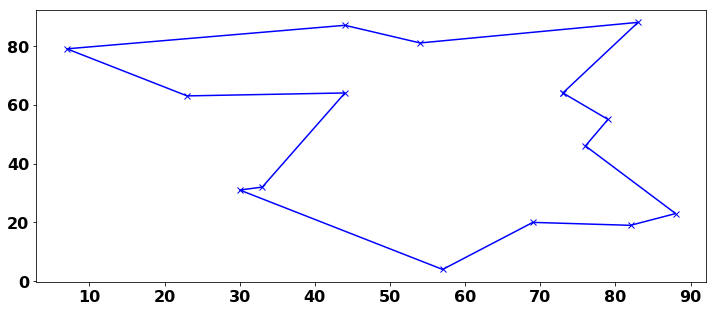

In [130]:
plot_solution(cities, tour)

In [138]:
# plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
from scipy.stats import sem

def plot_learning(iterations: int, lengths, disp_iter=1000):
    bin_size = int(iterations // float(min([iterations, disp_iter])))
    errors = np.reshape(lengths, newshape=(-1, bin_size))
    iters = np.reshape(list(range(iterations)), newshape=(-1, bin_size))
    plt.errorbar(
        iters.mean(axis=1),
        errors.mean(axis=1),
        yerr=sem(errors, axis=1),
        fmt='--o',
    )
    plt.ylabel('distance')
    plt.xlabel('iterations')

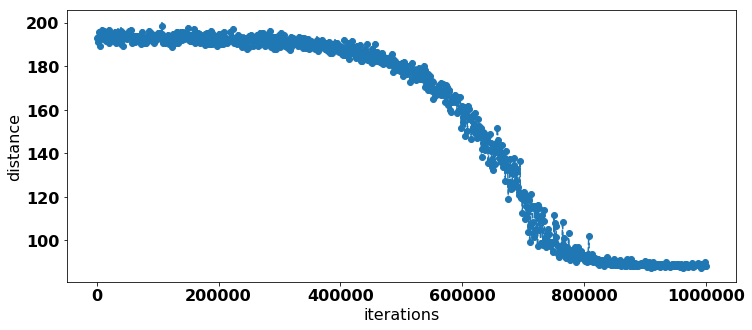

In [140]:
plot_learning(1000000, lengths)

# Ant Colony Optimization

In [142]:
pip install scikit-opt

Note: you may need to restart the kernel to use updated packages.


In [147]:
from scipy import spatial

distance_matrix = spatial.distance.cdist(cities, cities, metric='euclidean')
num_points = cities.shape[0]

In [ ]:
from sko.ACA import ACA_TSP

def cal_total_distance(tour):
    '''The objective function. input tour, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    return sum([
        distance_matrix[tour[i % N], tour[(i + 1) % N]]
        for i in range(N)
    ])

aca = ACA_TSP(func=cal_total_distance, n_dim=N,
              size_pop=num_points, max_iter=200,
              distance_matrix=distance_matrix)

best_x, dist = aca.run()

In [153]:
import pandas as pd

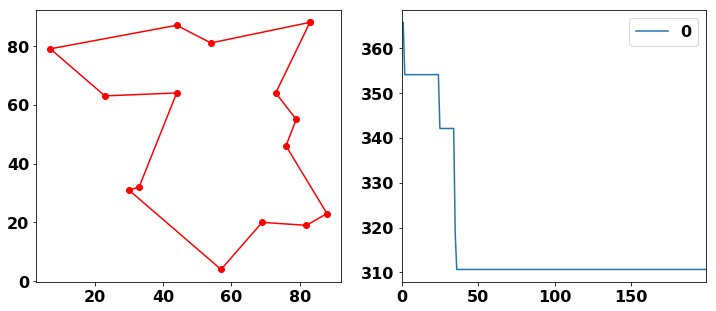

In [154]:
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = cities[best_points_, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])

https://www.sciencedirect.com/science/article/pii/S1570866711000682
> A comparison with evolutionary and genetic approaches indicates that ACO is among the best known metaheuristics for the all-pairs shortest paths problem.

# Mixed Integer Programming

In [155]:
pip install mip

     |████████████████████████████████| 48.4MB 74kB/s s eta 0:00:01   |██▌                             | 3.9MB 2.8MB/s eta 0:00:17
Note: you may need to restart the kernel to use updated packages.


In [159]:
from itertools import product
from mip import Model, xsum, minimize, BINARY
# adapted from https://python-mip.readthedocs.io/en/latest/examples.html

# number of nodes and list of vertices
n, V = len(cities), set(range(len(cities)))

# distances matrix
c = distance_matrix

model = Model()

# binary variables indicating if arc (i,j) is used on the route or not
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# continuous variable to prevent subtours: each city will have a
# different sequential id in the planned route except the first one
y = [model.add_var() for i in V]

# objective function: minimize the distance
model.objective = minimize(xsum(c[i][j]*x[i][j] for i in V for j in V))

# constraint : leave each city only once
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

# constraint : enter each city only once
for i in V:
    model += xsum(x[j][i] for j in V - {i}) == 1

# subtour elimination
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[i] - (n+1)*x[i][j] >= y[j]-n

# optimizing
model.optimize(max_seconds=30)

# checking if a solution was found
if model.num_solutions:
    tour = []
    print(
        'route with total distance %g found'
        % model.objective_value
    )
    nc = 0
    while True:
        nc = [i for i in V if x[nc][i].x >= 0.99][0]
        tour.append(nc)
        #print(' -> %s' % places[nc])
        if nc == 0:
            break

route with total distance 310.68 found


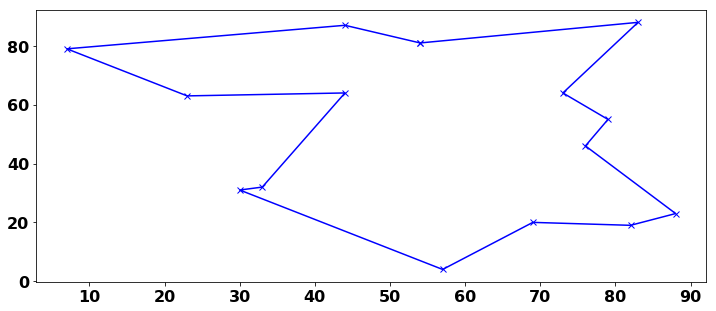

In [161]:
plot_solution(cities, tour)

In [ ]:
# tsp in pyomo: https://github.com/Pyomo/pyomo/blob/master/examples/pyomo/callbacks/tsp.py

In [ ]:
# https://scikit-opt.github.io/scikit-opt/#/en/
Powerful Python module for Heuristic Algorithms

Differential Evolution
Genetic Algorithm
Particle Swarm Optimization
Simulated Annealing
Ant Colony Algorithm
Immune Algorithm
Artificial Fish Swarm Algorithm
# see more examples from scikit-opt: https://scikit-opt.github.io/scikit-opt/#/en/README?id=_22-genetic-algorithm-for-tsptravelling-salesman-problem

In [ ]:
# find other mathematical optimization software on wikipedia: https://en.wikipedia.org/wiki/List_of_optimization_software

other packages similar to scikit-opt: 
* https://pyswarms.readthedocs.io/en/latest/index.html


how to solve the tsp with other methods:
* a hopfield network: https://www.tutorialspoint.com/artificial_neural_network/artificial_neural_network_optimization_using_hopfield.htm
* cuckoo search https://github.com/Ashwin-Surana/cuckoo-search


In [ ]:
# 30000 public buses, minibuses, and vans in Mexico 
# https://thelivinglib.org/mapaton-cdmx/

# finding the shortest path


In [ ]:
# https://en.wikipedia.org/wiki/Dijkstra's_algorithm
# https://gist.github.com/econchick/4666413